In [2]:
%load_ext autoreload
%autoreload 2

import os
os.chdir('/projects/cft_vlm/finetune')

In [3]:
import transformers
import torch
from copy import deepcopy
model = transformers.Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct",
    torch_dtype=torch.bfloat16,
    device_map="auto",
    attn_implementation="eager",
)
processor = transformers.AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct", use_fast=True)
gen_config = deepcopy(model.generation_config)
gen_config.max_new_tokens = 64
gen_config.do_sample = False

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


In [4]:

import logging

logging.basicConfig(level=logging.ERROR)
for name in logging.root.manager.loggerDict:
  logging.getLogger(name).setLevel(logging.ERROR)


In [5]:
import random
from qwenvl.data.input_processor import VISION_END, VISION_START, pad_and_stack_tensors
import matplotlib.pyplot as plt
import datasets
from tqdm import tqdm
from qwenvl.argument import ProcessingArguments, DataArguments
from qwenvl.module import create_module, create_strategies

import torch.nn.functional as F

## VQA RAD

In [ ]:

data_args = DataArguments(
    dataset_use='vqa_rad',
    split='test',
    packing=False,
    model_max_length=512,)

proc_args = ProcessingArguments(
    use_chat_template=True,
    sys_prompt="default",
    add_generation_prompt=True,
    use_bf16=True
)
def get_attention(model, data_args, processor, proc_args, gen_config, sample):
    strategies, cp, ip = create_strategies(processor, data_args, proc_args, rank=0)
    ds, collate = create_module(data_args, strategies, cp, ip)

    vs_id = processor.tokenizer.convert_tokens_to_ids(VISION_START)
    ve_id = processor.tokenizer.convert_tokens_to_ids(VISION_END)
    attns = []
    avg_attns = []
    results = []
    max_len = 0
    if sample is None:
      sample = range(len(ds))
    
    with torch.no_grad():
      for idx in tqdm(sample):
        item = ds[idx]
        inputs = collate(item).to(model.device)
        vs_idx = (torch.where(torch.eq(inputs.input_ids, vs_id))[1].item())
        ve_idx = (torch.where(torch.eq(inputs.input_ids, ve_id))[1].item())
        output = model.generate(**inputs, return_dict_in_generate=True,
                            output_attentions=True, generation_config=gen_config)
        attn = [[] for _ in range(len(output.attentions[0]))]
        gen_seq_len = output.sequences.shape[1] - inputs.input_ids.shape[1]
        max_len = max(max_len, gen_seq_len)
        for token_idx, token_attn in enumerate(output.attentions):
          for layer_idx, layer_attn in enumerate(token_attn):
            # layer.shape is [batch_size = 1, num_heads, q_len, k_len]
            layer_attn = layer_attn.squeeze(0)
            pad_len = gen_seq_len - token_idx - 1
            attn[layer_idx].append(F.pad(layer_attn, (0, pad_len), value=0.0)[:, -1])
            
        for layer_idx, layer_attn in enumerate(attn):
          attn[layer_idx] = torch.stack(layer_attn, dim=1).detach().cpu()
        
        attn = torch.stack(attn, dim=0)
        attns.append(attn)
        avg_attns.append(attn[..., vs_idx+1:ve_idx].mean(dim=-1))
        generated_ids = output.sequences[0][inputs.input_ids.shape[1]:]
        results.append(ip.tokenizer.convert_ids_to_tokens(generated_ids))

    for idx, avg_attn in enumerate(avg_attns):
      avg_attns[idx] = F.pad(avg_attn, (0, max_len - avg_attn.shape[-1]), value=torch.nan)
    avg_attns = torch.stack(avg_attns, dim=0)
    return attns, avg_attns, results
  
sample = None
d_attns, d_avg_attns, d_results, = get_attention(model, data_args, processor, proc_args, gen_config, sample)
proc_args = ProcessingArguments(
  use_chat_template=True,
  sys_prompt="default,just_focus",
  add_generation_prompt=True,
  use_bf16=True
)
f_attns, f_avg_attns, f_results = get_attention(model, data_args, processor, proc_args, gen_config, sample)

In [ ]:
import random

layer = 1
head_idx = 0
fig, ax = plt.subplots(figsize=(20, 6), nrows=2, ncols=1)
idx = random.randint(0, 100)
ax.flat[0].plot(d_avg_attns[idx, layer, head_idx].to(torch.float32).numpy(), label='default')
ax.flat[0].xaxis.set_ticks(range(len(d_results[idx])), labels=d_results[idx], rotation=45)
ax.flat[0].grid()
fig.subplots_adjust(hspace=0.6)
ax.flat[1].plot(f_avg_attns[idx, layer, head_idx].to(torch.float32).numpy(), label='focused', color='orange')
ax.flat[1].xaxis.set_ticks(range(len(f_results[idx])), labels=f_results[idx], rotation=45)
ax.flat[1].grid()
ax.flat[0].set_title(f'Average Attention Weights for Layer {layer + 1}')
fig.legend()
fig.show()

In [ ]:
d_avg_attns.shape


In [ ]:
fig, ax = plt.subplots(figsize=(9, 6))
plot_avg_attn_w_interval(d_avg_attns.mean(dim=(1, 2)).to(torch.float32), f_avg_attns.mean(dim=(1, 2)).to(torch.float32), ax, None)

In [ ]:
import matplotlib.pyplot as plt

def plot_avg_attn_w_interval(d_avg_attns, f_avg_attns, ax, idx):
  for avg_attns, label, color, fill_color in [
    (d_avg_attns, 'default', '#1f77b4', 'lightblue'),  # blue variant
    (f_avg_attns, 'focus prompt', '#d62728', 'lightcoral')     # red variant
  ]:
    mean = avg_attns.nanmean(dim=0).numpy()
    q25 = torch.nanquantile(avg_attns, 0.25, dim=0).numpy()
    q75 = torch.nanquantile(avg_attns, 0.75, dim=0).numpy()
    ax.plot(mean, label=label, color=color, linewidth=2)
    ax.fill_between(range(len(mean)), q25, q75, color=fill_color, alpha=0.3)
  ax.grid(True, linestyle='--', alpha=0.6)
  
  if idx is not None:
    ax.set_title(f'Layer {idx + 1}')
  else:
    ax.set_title('Averaged Across All Layers')
    
fig, axes = plt.subplots(9, 4, figsize=(16, 36))
for idx in range(d_avg_attns.shape[1]):
  plot_avg_attn_w_interval(d_avg_attns[:, idx].mean(dim=1).to(torch.float32), f_avg_attns[:, idx].mean(dim=1).to(torch.float32), axes.flat[idx], idx)

fig.show()

In [ ]:
d_avg_attns.shape

In [ ]:
import os

def save_attentions(folder, attns, avg_attns):
  os.makedirs(folder, exist_ok=True)
  torch.save(attns, os.path.join(folder, "attns.pt"))
  torch.save(avg_attns, os.path.join(folder, "avg_attns.pt"))

def load_attentions(folder):
  attns = torch.load(os.path.join(folder, "attns.pt"))
  avg_attns = torch.load(os.path.join(folder, "avg_attns.pt"))
  return attns, avg_attns
folder_name = 'd_attn_168'

save_attentions('d_attn_168', d_attns, d_avg_attns)
save_attentions('f_attn_168', f_attns, f_avg_attns)

## MNIST

In [6]:
mnist_gen_config = deepcopy(gen_config)
mnist_gen_config.max_new_tokens = 1
data_args = DataArguments(
    dataset_use='fashion_mnist',
    split='test',
    packing=False,
    model_max_length=512,)

proc_args = ProcessingArguments(
    use_chat_template=True,
    sys_prompt="default",
    usr_prompt='fashion_mnist',
    add_generation_prompt=True,
    use_bf16=True
)

def get_attention(model, data_args, processor, proc_args, gen_config, sample):
    strategies, cp, ip = create_strategies(processor, data_args, proc_args, rank=0)
    ds, collate = create_module(data_args, strategies, cp, ip)

    vs_id = processor.tokenizer.convert_tokens_to_ids(VISION_START)
    ve_id = processor.tokenizer.convert_tokens_to_ids(VISION_END)
    attns = []
    avg_attns = []
    results = []
    labels = []
    max_len = 0
    
    with torch.no_grad():
      for idx in tqdm(sample):
        item = ds[idx]
        label = item[0]['label']
        inputs = collate(item).to(model.device)
        vs_idx = (torch.where(torch.eq(inputs.input_ids, vs_id))[1].item())
        ve_idx = (torch.where(torch.eq(inputs.input_ids, ve_id))[1].item())
        output = model.generate(**inputs, return_dict_in_generate=True,
                            output_attentions=True, generation_config=gen_config)
        attn = [[] for _ in range(len(output.attentions[0]))]
        gen_seq_len = output.sequences.shape[1] - inputs.input_ids.shape[1]
        max_len = max(max_len, gen_seq_len)
        for token_idx, token_attn in enumerate(output.attentions):
          for layer_idx, layer_attn in enumerate(token_attn):
            # layer.shape is [batch_size = 1, num_heads, q_len, k_len]
            layer_attn = layer_attn.squeeze(0)
            pad_len = gen_seq_len - token_idx - 1
            attn[layer_idx].append(F.pad(layer_attn, (0, pad_len), value=0.0)[:, -1])
            
        for layer_idx, layer_attn in enumerate(attn):
          attn[layer_idx] = torch.stack(layer_attn, dim=1).detach().cpu()
        
        attn = torch.stack(attn, dim=0)
        attns.append(attn)
        avg_attns.append(attn[:, :, -gen_seq_len:, vs_idx+1:ve_idx].mean(dim=-1))
        generated_ids = output.sequences[0][inputs.input_ids.shape[1]:]
        results.append(ip.tokenizer.convert_ids_to_tokens(generated_ids))
        labels.append(label)

    for idx, avg_attn in enumerate(avg_attns):
      avg_attns[idx] = F.pad(avg_attn, (0, max_len - avg_attn.shape[-1]), value=torch.nan)
    avg_attns = torch.stack(avg_attns, dim=0)
    return attns, avg_attns, results, labels

m_attns, m_avg_attns, m_results, m_labels = get_attention(model, data_args, processor, proc_args, mnist_gen_config, range(100))

2025-07-22 15:34:30,074 - qwenvl.module - WARNING - CFT prompt  not found, not using it.
2025-07-22 15:34:30,075 - qwenvl.module - INFO - Using user prompt fashion_mnist


2025-07-22 15:34:30,076 - qwenvl.module - INFO - Using system prompt default
2025-07-22 15:34:30,691 - qwenvl.module - INFO - Creating module for dataset fashion_mnist with split test
2025-07-22 15:34:31,803 - qwenvl.module - INFO - Applying strategy SaveStrategy
2025-07-22 15:34:31,804 - qwenvl.data.preprocess - INFO - Saving dataset to /projects/cft_vlm/datasets/fasion_mnist/data/dataset.
2025-07-22 15:34:31,893 - qwenvl.data.preprocess - INFO - Dataset split 'train' DNE or has changed. Overwriting.


Saving the dataset (0/1 shards):   0%|          | 0/60000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

2025-07-22 15:34:32,701 - qwenvl.data.preprocess - INFO - Temporary dataset saved to /projects/cft_vlm/datasets/fasion_mnist/data/dataset_tmp.
2025-07-22 15:34:32,703 - qwenvl.data.preprocess - INFO - Removed existing dataset at /projects/cft_vlm/datasets/fasion_mnist/data/dataset.
2025-07-22 15:34:32,704 - qwenvl.data.preprocess - INFO - Dataset saved to /projects/cft_vlm/datasets/fasion_mnist/data/dataset.
2025-07-22 15:34:32,732 - qwenvl.module - INFO - Example from dataset: [[{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x7FABDDC5B640>, 'label': 9}], [{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x7FABDDC5B6A0>, 'label': 2}]]
2025-07-22 15:34:32,733 - qwenvl.module - INFO - Example after conversation processing: [[{'role': 'system', 'content': 'You are a helpful assistant.'}, {'role': 'user', 'content': [{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x7FABDDC5B640>}, {'text': 'Choose from the following option

100%|██████████| 100/100 [00:18<00:00,  5.47it/s]


In [7]:
def is_correct(labels, results) -> torch.Tensor:
  correct = torch.zeros(len(labels))
  for idx, (label, result) in enumerate(zip(labels, results)):
    if str(label) == result[0]:
      correct[idx] = 1
  return correct

m_avg_attns = m_avg_attns.permute(1, 2, 0, 3)  # [num_layers, num_heads, batch_size, seq_len]
m_correct = is_correct(m_labels, m_results).view(1, 1, -1, 1).expand(m_avg_attns.shape)
torch.mean(m_correct, dtype=torch.float)

tensor(0.4600)

/tmp/ipykernel_7042/4064117660.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  coolwarm = cm.get_cmap('coolwarm').copy()


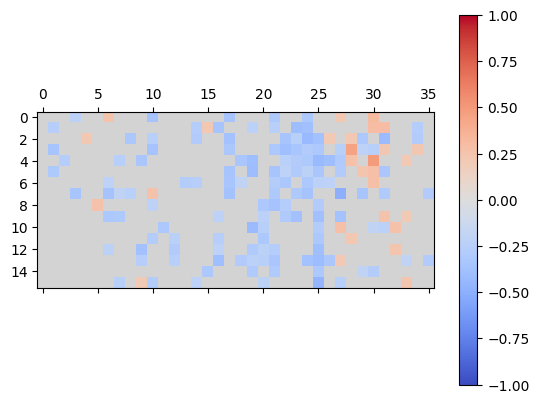

In [10]:
from scipy.stats import pearsonr

corr = pearsonr(m_correct.to(torch.float32), m_avg_attns.to(torch.float32), axis=2)
import numpy as np
from matplotlib import cm

fig, axes = plt.subplots(1, 1)

mask = corr.pvalue[..., 0] > 0.05
masked_stat = np.ma.masked_where(mask, corr.statistic[..., 0])
masked_stat = masked_stat.T

coolwarm = cm.get_cmap('coolwarm').copy()
coolwarm.set_bad('lightgray')
cb0 = axes.matshow(masked_stat, cmap=coolwarm, vmin=-1, vmax=1)
fig.colorbar(cb0, ax=axes)
fig.show()

In [11]:
mean_result = pearsonr(m_correct.to(torch.float32).mean(dim=(0, 1)), m_avg_attns.to(torch.float32).mean(dim=(0, 1)), axis=0)
mean_result

PearsonRResult(statistic=array([-0.09057004], dtype=float32), pvalue=array([0.37016857], dtype=float32))